In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import bangla_nlp
import torch.nn as nn

In [43]:
df=pd.read_csv('Bengali hate speech .csv')
df.head()

,sentence,hate,category
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports


In [44]:
print("Hate-Non hate distribution")
df['hate'].value_counts()


Hate-Non hate distribution


hate
0    20000
1    10000
Name: count, dtype: int64

In [45]:
df_filtered=df[df['hate']==1]
print("Number of hate comments in every category")
df_filtered['category'].value_counts()


Number of hate comments in every category


category
crime                      2000
entertainment              1627
sports                     1601
religion                   1570
Meme, TikTok and others    1563
politics                    886
celebrity                   753
Name: count, dtype: int64

<h1>Data Preprocessing</h1>

<h5>Cleaning Text</h5>

In [46]:

# remove punctuations
df['clean_punctuation']=df['sentence'].apply(bangla_nlp.clean_punctuations)
df['clean_emoji']=df['clean_punctuation'].apply(bangla_nlp.clean_emoji)
df['clean_text']=df['clean_emoji'].apply(bangla_nlp.clean_url_and_email)
df['clean_text']=df['clean_text'].apply(bangla_nlp.clean_digits)
drop_columns=['clean_punctuation','clean_emoji']
df.drop(columns=drop_columns,inplace=True)
df.head()


,sentence,hate,category,clean_text
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব


<h5>Tokenization</h5>

In [47]:
df['tokenized_words']=df['clean_text'].apply(bangla_nlp.word_tokenize_texts)
df.head()

,sentence,hate,category,clean_text,tokenized_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ..."


In [48]:
df['no_stopword_tokenized_words']=df['tokenized_words'].apply(bangla_nlp.remove_stopwords_from_tokens)
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব..."


<h5>Class Imbalance Identification</h5>

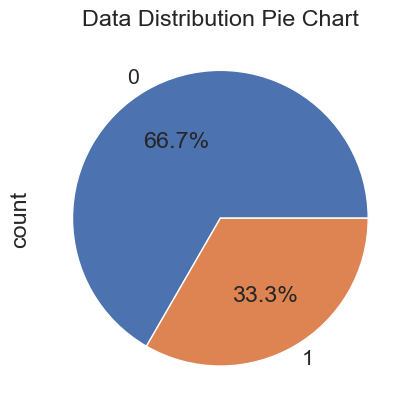

In [49]:
value_counts=df['hate'].value_counts()
# Plot a pie chart
value_counts.plot.pie(autopct='%.1f%%')
# Add a title
plt.title("Data Distribution Pie Chart")
# Show the plot
plt.show()

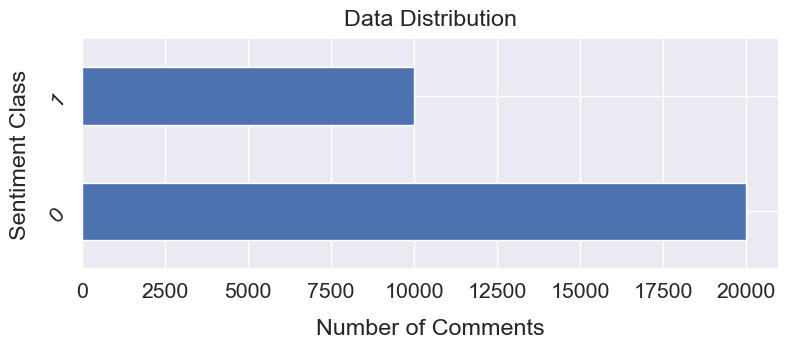

In [50]:
sns.set(font_scale=1.4)
df['hate'].value_counts().plot(kind='barh', figsize=(9, 3))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Data Distribution", y=1.02);

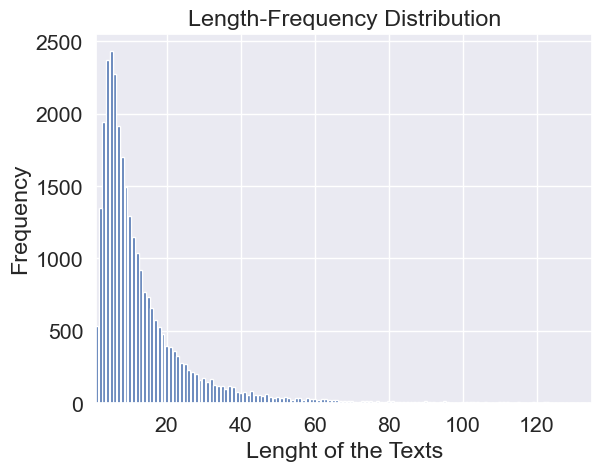

Maximum Length of a review: 537
Minimum Length of a review: 1
Average Length of a reviews: 15.0


In [51]:
# Calculate the Review of each of the Review
df['ReviewLength'] = df.sentence.apply(lambda x:len(x.split()))
frequency = dict()
for i in df.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a review: {max(df.ReviewLength)}")
print(f"Minimum Length of a review: {min(df.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(df.ReviewLength),0)}")

<!-- As there is a minority class, the dataset needs oversampling -->

In [52]:
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words,ReviewLength
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]",4
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]",6
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...",20
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]",7
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব...",9


In [53]:
# count the number of samples in each class
class_counts = df['hate'].value_counts()
print(class_counts)

hate
0    20000
1    10000
Name: count, dtype: int64


In [54]:
# identify the class with the least samples
min_class = class_counts.idxmin()
max_class = class_counts.idxmax()
# calculate the number of samples required to balance the classes
upsample_size = class_counts[max_class] - class_counts[min_class]
print(upsample_size)
## applying upsampling. 
# upsample the minority class to balance the classes
# It samples the data from the data frame with replacement, meaning that it can choose the same sample multiple times.
df_minority_upsampled = df[df['hate'] == min_class].sample(n=upsample_size, replace=True, random_state=42)
df_upsampled = pd.concat([df, df_minority_upsampled])
# shuffle the samples in the balanced dataset
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
# save the balanced dataset to a file

10000


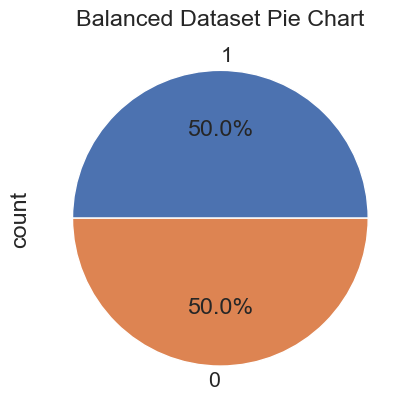

In [55]:

value_counts = df_upsampled['hate'].value_counts()

# Plot a pie chart
value_counts.plot.pie(autopct='%.1f%%')

# Add a title
plt.title("Balanced Dataset Pie Chart")

# Show the plot
plt.show()

In [56]:
df['clean_string_words']=df['no_stopword_tokenized_words'].apply(' '.join)
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words,ReviewLength,clean_string_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]",4,যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]",6,পাপন শালা রে রিমান্ডে দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...",20,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ একটা দে...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]",7,শালা লুচ্চা পাঠার মত যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব...",9,তুই শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব


<h1>Model Building</h1>

<h5>Split Dataset into train, test set</h5>

In [57]:
from sklearn.model_selection import train_test_split

# Split dataset into training+validation and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, validation_data = train_test_split(df, test_size=0.25, random_state=42)

In [58]:
# Tokenize the data
def tokenize_texts(texts, max_length):
    tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokenized_texts

max_length=128

train_tokenized_texts = tokenize_texts(train_data['clean_string_words'].tolist(), max_length)
test_tokenized_texts = tokenize_texts(train_data['clean_string_words'].tolist(), max_length)
validation_tokenized_texts = tokenize_texts(validation_data['clean_string_words'].tolist(), max_length)



In [59]:
# Prepare train and test inputs and labels
train_inputs = {
    'input_ids': train_tokenized_texts['input_ids'],
    'attention_mask': train_tokenized_texts['attention_mask']
}

train_labels = torch.tensor(train_data['hate'].values,dtype=torch.float32).unsqueeze(1)



test_inputs = {
    'input_ids': test_tokenized_texts['input_ids'],
    'attention_mask': test_tokenized_texts['attention_mask']
}

test_labels = torch.tensor(test_data['hate'].values,dtype=torch.float32).unsqueeze(1)


validation_inputs = {
    'input_ids': validation_tokenized_texts['input_ids'],
    'attention_mask': validation_tokenized_texts['attention_mask']
}

validation_labels = torch.tensor(validation_data['hate'].values,dtype=torch.float32).unsqueeze(1)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [61]:
# Bangla Bert model
class CyberBullyingClassifier(nn.Module):
    def __init__(self):
        super(CyberBullyingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        probability = self.sigmoid(logits)
        return probability

In [62]:
# Create model instance
model = CyberBullyingClassifier()
model.to(device)

CyberBullyingClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [63]:
# Defining optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 100
total_steps = len(train_inputs['input_ids']) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Defining loss function
criterion = nn.BCELoss()

In [64]:
def train_model(model, train_inputs, train_labels, criterion, optimizer, scheduler, device, batch_size=32, epochs=epochs):
    model.train()
    best_loss=float('inf')
    wait=0
    epsilon=1e-8
    patience_counter=3
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(train_inputs['input_ids']), batch_size):
            inputs = {key: val[i:i+batch_size].to(device) for key, val in train_inputs.items()}
            labels = train_labels[i:i+batch_size].to(device)

            optimizer.zero_grad()

            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * batch_size

        epoch_loss = running_loss / len(train_labels)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
        
        if epoch_loss<best_loss-epsilon:
            best_loss=epoch_loss
            wait=0
        else:
            wait+=1
            if wait >=patience_counter:
                print(f'Stopping early at epoch {epoch+1} due to insignificant loss change.')
                break

# Training the model
train_model(model, train_inputs, train_labels, criterion, optimizer, scheduler, device)

In [ ]:
from sklearn.metrics import accuracy_score
def evaluate_model(model, test_inputs, test_labels, device, batch_size=32):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for i in range(0, len(test_inputs['input_ids']), batch_size):
            inputs = {key: val[i:i+batch_size].to(device) for key, val in test_inputs.items()}
            labels = test_labels[i:i+batch_size].to(device)

            outputs = model(**inputs)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    preds = np.array(preds) >= 0.5
    accuracy = accuracy_score(true_labels, preds)
    return accuracy

# Evaluating the model
accuracy = evaluate_model(model, test_inputs, test_labels, device)
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
# saving the model
torch.save(model.state_dict(), 'G:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield\Created Models/bangla_bert.pth')